# NRS - Project Work - Group 1

### Importing Libraries and Data

In [27]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# regular expressione and tools for sentiment analysis
from textblob import TextBlob
import re 

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, classification_report # plot confusion matrix
from sklearn.model_selection import train_test_split #split train & test
from sklearn.model_selection import GridSearchCV #gridsearch
from sklearn.metrics import classification_report #further metric

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC

In [2]:
missing_values = [''] #define values to be identified as NaN in the datasets 
#,'Undefined', 'Undefined->Undefined'

df_crm = pd.read_csv('crm_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import CRM_model
df_finance = pd.read_csv('finance_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import finance_model
df_sales = pd.read_csv('sales_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import sales_model
df_twitter = pd.read_csv('twitter_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import twitter_azure

<a id="Joining_Datasets"></a>

### Merging Datasets

In [3]:
# column id renaming to join the datasets
df_crm = df_crm.rename(columns={'ID_CRM': 'id'}) 
df_finance = df_finance.rename(columns={'ID_FINANCE': 'id'})
df_sales = df_sales.rename(columns={'ID_SALES': 'id'})
df_twitter = df_twitter.rename(columns={'ID_SALES': 'id'})

By observing the structure of each id we find a pattern to extract a common unique id:

<img src="img/ID_schema.png"></img>

In [4]:
# df_crm unique_id extraction
df_crm.id = np.where(df_crm.Income_Level.str.len() == 2,\
                     df_crm.id.str.slice(start = 1, stop = -2),\
                     df_crm.id.str.slice(start = 1, stop = -1))

# df_finance unique_id extraction
df_finance.id = np.where(df_finance.Special_Pay.str.len() == 2,\
                         df_finance.id.str.slice(start = 2),\
                         df_finance.id.str.slice(start = 0))

# df_sales unique_id extraction
df_sales.id = np.where(df_sales.Program_Code.str.len() == 2,\
                       df_sales.id.str.slice(start = 2, stop = -1),\
                       df_sales.id.str.slice(start = 3, stop = -1))

# df_twitter unique_id extraction
df_twitter.id = df_twitter.id.str.extract(r'(\d+)', expand=False)

#### Sentiment Analysis

In [5]:
# Create a function to clean the tweets
def cleanTxt(text):
    text = text.lower()
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub('&amp;', '', text) #remove ampersand
    text = re.sub('\n',' ', text) #remove breakline
    text = re.sub("[^\w]", " ",  text) #remove all distinct to word
    text = re.sub('å', '', text)
    text = re.sub('ä', '', text)
    text = re.sub('ā', '', text)


    text = re.sub(' +', ' ', text) #remove multiple spaces

    # clean emoticons
    return text

In [6]:
# Clean the tweets
df_twitter['text'] = df_twitter['text'].apply(cleanTxt)

In [7]:
#get the sentiment of each tweet first, then calculate the mean

#df_twitter_merged = df_twitter.copy()
#df_twitter_merged['polarity'] = df_twitter_merged['text'].apply(lambda x: TextBlob(x).sentiment[0])
#df_twitter_merged['subjectivity'] = df_twitter_merged['text'].apply(lambda x: TextBlob(x).sentiment[1])

#df_twitter_merged = df_twitter_merged.groupby('id').mean()

#df_twitter_merged

In [8]:
# Chain all tweets referencing the same ID first, then get sentiment
# Grouping all tweets referencing the same id
df_twitter['merged_text'] = df_twitter.groupby('id')['text'].transform(lambda x: ' '.join(x))
df_twitter_merged = df_twitter[{'id','merged_text'}].drop_duplicates()
df_twitter_merged.reset_index(drop=True, inplace=True)

# sentiment analysis
df_twitter_merged['merged_text'].apply(lambda x: TextBlob(x).sentiment[0])
df_twitter_merged['polarity'] = df_twitter_merged['merged_text'].apply(lambda x: TextBlob(x).sentiment[0])
df_twitter_merged['subjectivity'] = df_twitter_merged['merged_text'].apply(lambda x: TextBlob(x).sentiment[1])
df_twitter_merged.drop(columns = ['merged_text'], inplace=True)

In [9]:
# create a single table to join the datasets
df_merged = df_sales.merge(df_crm, on="id", how="inner").merge(df_finance, on="id", how="inner").merge(df_twitter_merged, on="id", how="left")
df_merged.shape

(4148, 56)

### Data preparation

In [10]:
df = df_merged.copy()

In [11]:
def dummification(df):
    
    #_______________ Categorical Dummification
    categorical = df.select_dtypes(exclude=np.number).columns.tolist()
    df = pd.get_dummies(df, columns = categorical, prefix = categorical)
    
    return df

In [12]:
def cleaning_1(df):
    #______________ id
    df.drop(columns=['id'], inplace=True)


    #______________ Program_Code
    #wrong value replaced with na
    df['Program_Code'] = df['Program_Code'].replace({'FN': np.nan})
    #missing values replaced with mode of the parent group
    df['Program_Code'] = df.groupby(['MajorProgramCode'], sort=False)['Program_Code'].apply(lambda x: x.fillna(x.mode().iloc[0]))


    #______________ From_Grade
    #missing values replaced with the median
    df['From_Grade'] = df['From_Grade'].fillna(df['From_Grade'].median())


    #______________ To_Grade
    #missing values replaced with the median (with respect to the subgroup)
    df['To_Grade'] = df.groupby(['From_Grade'], sort=False)['To_Grade'].apply(lambda x: x.fillna(x.median()))
    df['To_Grade'] = df['To_Grade'].fillna(df['To_Grade'].median())


    #____**NEW**____ Delta_From_To_Grade
    #new variable
    df['Delta_From_To_Grade'] = df['To_Grade'] - df['From_Grade']


    #conversion to datetime
    df['Departure_Date'] = pd.to_datetime(df['Departure_Date'])


    #____**NEW**____ Departure_Date_DoY
    #conversion to day of the year
    df['Departure_Date_DoY'] = df['Departure_Date'].dt.dayofyear

    #_______________ Return_Date
    #conversion to datetime
    df['Return_Date'] = pd.to_datetime(df['Return_Date'])


    #____**NEW**____ Return_Date_DoY
    #conversion to day of the year
    df['Return_Date_DoY'] = df['Return_Date'].dt.dayofyear


    #_______________ Early_RPL
    #_______________ Latest_RPL
    #____**NEW**____ RPL_Value
    df['Early_RPL'] = pd.to_datetime(df['Early_RPL'])
    df['Latest_RPL'] = pd.to_datetime(df['Latest_RPL'])

    df['RPL_Value'] = np.where( (df['Early_RPL'].isna()) & (df['Latest_RPL'].isna()), 0, 1)

    df['Early_RPL'].fillna(df['Latest_RPL'].mode()[0], inplace=True)
    df['Latest_RPL'].fillna(df['Latest_RPL'].mode()[0], inplace=True)

    temp_min = df[['Early_RPL','Latest_RPL']].min(axis=1)
    temp_max = df[['Early_RPL','Latest_RPL']].max(axis=1)

    df['Early_RPL'] = temp_min
    df['Latest_RPL'] = temp_max


    #____**NEW**____ Early_RPL_DoY
    #____**NEW**____ Latest_RPL_DoY
    df['first_january'] = pd.to_datetime('1/1/' + str(df['Departure_Date'].dt.year[0]))
    df['Early_RPL_DoY'] = df['Early_RPL'] - df['first_january']
    df['Early_RPL_DoY'] = df['Early_RPL_DoY'].astype('timedelta64[D]').astype(int)
    df['Latest_RPL_DoY'] = df['Latest_RPL'] - df['first_january']
    df['Latest_RPL_DoY'] = df['Latest_RPL_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ Initial_System_Date
    df['Initial_System_Date'] = pd.to_datetime(df['Initial_System_Date'])
    df['Initial_System_Date'].fillna(df['Initial_System_Date'].mode()[0], inplace=True)


    #____**NEW**____ Initial_System_Date_DoY
    df['Initial_System_Date_DoY'] = df['Initial_System_Date'] - df['first_january']
    df['Initial_System_Date_DoY'] = df['Initial_System_Date_DoY'].astype('timedelta64[D]').astype(int)


    #______________ DepartureMonth
    df.drop(columns=['DepartureMonth'], inplace=True)


    #_______________ GroupGradeTypeLow
    df['GroupGradeTypeLow'] = df['GroupGradeTypeLow'].fillna(df['GroupGradeTypeLow'].mode()[0])


    #_______________ GroupGradeTypeHigh
    df['GroupGradeTypeHigh'] = df.groupby(['GroupGradeTypeLow'], sort=False)['GroupGradeTypeHigh'].apply(lambda x: x.fillna(x.mode()[0]))
    df['GroupGradeTypeHigh'] = df['GroupGradeTypeHigh'].fillna(df['GroupGradeTypeHigh'].mode()[0])


    #_______________ GroupGradeType
    df['GroupGradeType'] = df['GroupGradeTypeLow'] + '->' + df['GroupGradeTypeHigh']


    #_______________ CRM_Segment
    df['CRM_Segment'].fillna(df['CRM_Segment'].mode()[0], inplace=True)


    #_______________ MDR_Low_Grade
    #_______________ MDR_High_Grade
    df['MDR_Low_Grade'].replace({'0': df['MDR_Low_Grade'].mode()[0]}, inplace=True)
    df['MDR_High_Grade'].replace({'NA': df['MDR_High_Grade'].mode()[0]}, inplace=True)


    #_______________ Total_School_Enrollment
    df['Total_School_Enrollment'] = df['Total_School_Enrollment'].replace({0: np.nan})
    df['Total_School_Enrollment'] = df['Total_School_Enrollment'].fillna(df['Total_School_Enrollment'].mean())


    #_______________ FPP_to_School_enrollment
    df['FPP_to_School_enrollment'] = df['FPP_to_School_enrollment'].fillna(df['FPP_to_School_enrollment'].mean())


    #____**NEW**____ FPP_to_School_enrollment_rev
    df['FPP_to_School_enrollment_rev'] = df['FPP'] / df['Total_School_Enrollment']


    #_______________ Poverty_Code
    df['Poverty_Code'] = df['Poverty_Code'].replace({'0': 'E'})


    #_______________ Income_Level
    df['Poverty_Code'] = df['Poverty_Code'].replace({'0': 'Z'})


    #_______________ FirstMeeting
    df['FirstMeeting'] = pd.to_datetime(df['FirstMeeting'])
    df['FirstMeeting'].fillna(df['FirstMeeting'].mode()[0], inplace=True)


    #____**NEW**____ FirstMeeting_DoY
    df['FirstMeeting_DoY'] = df['FirstMeeting'] - df['first_january']
    df['FirstMeeting_DoY'] = df['FirstMeeting_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ LastMeeting
    df['LastMeeting'] = pd.to_datetime(df['LastMeeting'])
    df['LastMeeting'].fillna(df['LastMeeting'].mode()[0], inplace=True)


    #____**NEW**____ LastMeeting_DoY
    df['LastMeeting_DoY'] = df['LastMeeting'] - df['first_january']
    df['LastMeeting_DoY'] = df['LastMeeting_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ DifferenceTraveltoFirstMeeting
    df['DifferenceTraveltoFirstMeeting'] = df['Departure_Date_DoY'] - df['FirstMeeting_DoY']


    #_______________ DifferenceTraveltoLastMeeting
    df['DifferenceTraveltoLastMeeting'] = df['Departure_Date_DoY'] - df['LastMeeting_DoY']


    #_______________ SchoolSizeIndicator
    df['SchoolSizeIndicator'].fillna(df['SchoolSizeIndicator'].mode()[0], inplace=True)


    #_______________ Deposit_Date
    df['Deposit_Date'] = pd.to_datetime(df['Deposit_Date'])


    #____**NEW**____ Deposit_Date_DoY
    df['Deposit_Date_DoY'] = df['Deposit_Date'] - df['first_january']
    df['Deposit_Date_DoY'] = df['Deposit_Date_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ Special_Pay
    df['Special_Pay'] = df['Special_Pay'].replace({'0': df['Special_Pay'].mode()[0]})
    
    
    #_______________ Polarity
    df['polarity'].fillna(df['polarity'].mean(), inplace=True)
    
    
    #_______________ Subjectivity
    df['subjectivity'].fillna(df['subjectivity'].mean(), inplace=True)
    

    #_______________ Drop Columns
    df.drop(columns=['first_january'], inplace=True)
    df.drop(columns=['Departure_Date', 'Return_Date', 'Early_RPL', 'Latest_RPL', 'FirstMeeting', 'LastMeeting', 'Initial_System_Date', 'Deposit_Date'], inplace=True)

In [13]:
cleaning_1(df)

### Data exploration

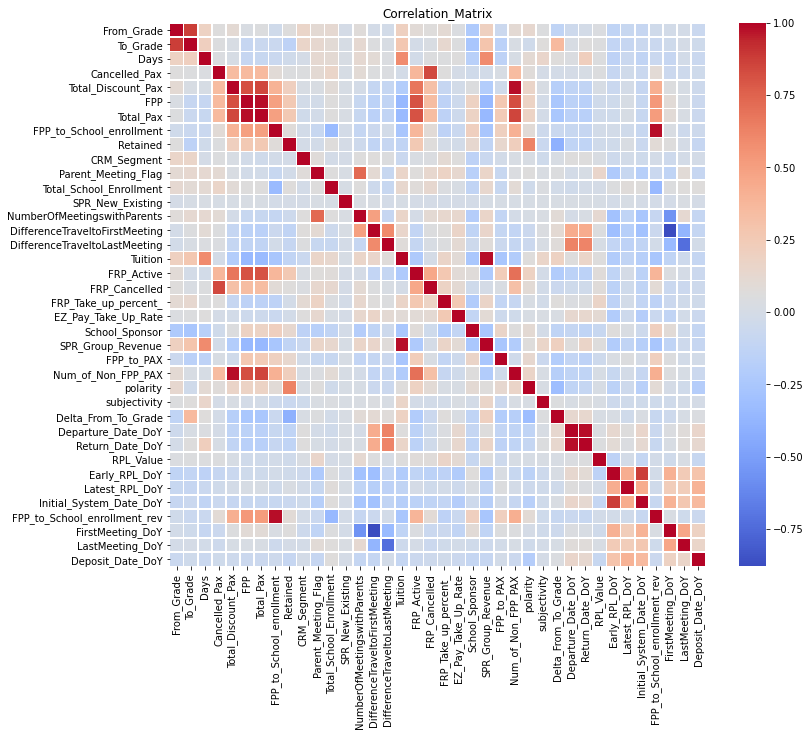

In [14]:
Numerical = df.select_dtypes(include=np.number).columns.tolist()
data_to_heatmap = df[Numerical]

plt.figure(figsize = (12,10))
sns.heatmap(data=data_to_heatmap.corr().round(2), cmap='coolwarm', linewidths=.5, annot=False, annot_kws={"size":10}).set_title('Correlation_Matrix')
plt.show()

<AxesSubplot:>

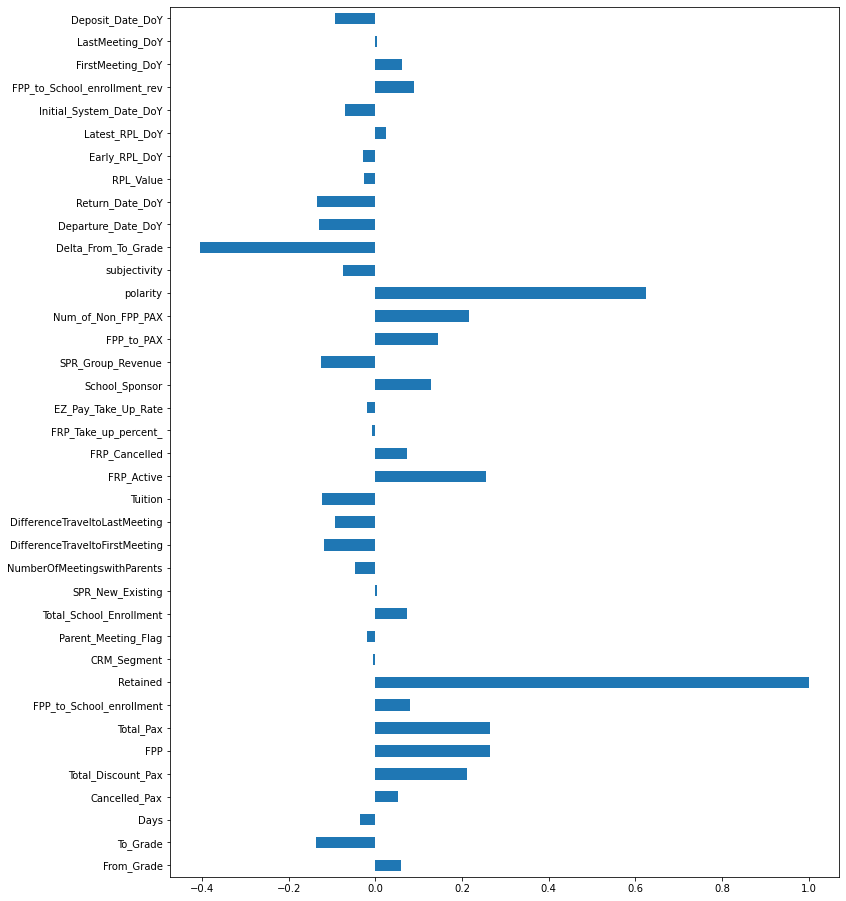

In [15]:
plt.figure(figsize = (12,16))
data_to_heatmap[data_to_heatmap.columns[:]].corr()['Retained'][:].plot(kind='barh')

<AxesSubplot:xlabel='polarity', ylabel='Count'>

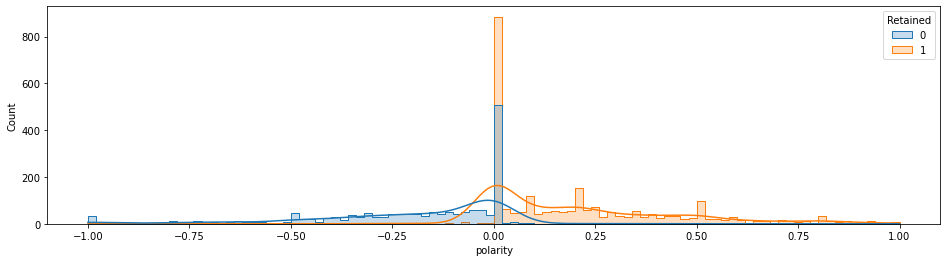

In [16]:
plt.figure(figsize=(16,4))
sns.histplot(data=df, x='polarity', hue="Retained", element="step", kde=True, bins=100)

In [17]:
df = dummification(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4148 entries, 0 to 4147
Columns: 241 entries, From_Grade to Special_Pay_SA
dtypes: float64(12), int32(7), int64(19), uint8(203)
memory usage: 2.1 MB


In [19]:
#df.to_excel("clean.xlsx")

## Models

In [20]:
X = df.drop(columns=['Retained'])
y = df['Retained']

In [21]:
#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,  #X_scaled
                                                    test_size =0.30, #by default is 75%-25%
                                                    #shuffle is set True by default,
                                                    stratify=y,
                                                    random_state= 2356) #fix random seed for replicability

print(X_train.shape)
print(X_test.shape)

(2903, 240)
(1245, 240)


### Classification Tree

In [22]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID

classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [4,5,6,7,8,9],
              'min_samples_split': [3,4,5,6,7,8,9],
              'min_samples_leaf': [3,4,5,6,7,8,9]}

In [23]:
#DEFINE YOUR GRIDSEARCH 
'''
GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
'''
gs = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

In [24]:
#TRAIN YOUR CLASSIFIER
gs = gs.fit(X_train, y_train)

Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1998s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 178 tas

In [28]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.948913 using {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 6}
0.922265 (0.003329) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3}
0.922566 (0.003778) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 4}
0.922265 (0.003329) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.922566 (0.003778) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 6}
0.922025 (0.003599) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 7}
0.922566 (0.003778) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 8}
0.922566 (0.003778) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 9}
0.922272 (0.003851) with: {'criterion': 'entropy', 'max_depth': 4

In [29]:
best_model = gs.best_estimator_

#TEST ON YOUR TEST & TRAIN SET 
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

#EVALUATE YOUR PREDICTION (on the y_train)
print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train))

print('\n')

#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred))

***RESULTS ON TRAIN SET***
f1_score:  0.9562043795620438


***RESULTS ON TEST SET***
f1_score:  0.9432717678100263


In [30]:
#PRINT SOME FURTHER METRICS
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       489
           1       0.94      0.95      0.94       756

    accuracy                           0.93      1245
   macro avg       0.93      0.93      0.93      1245
weighted avg       0.93      0.93      0.93      1245



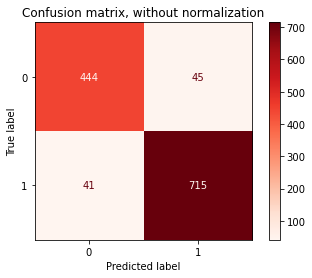

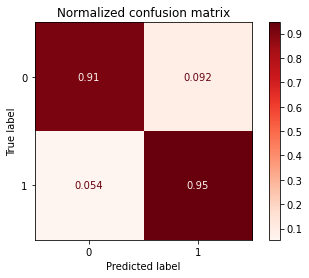

In [31]:
# Plot confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_model, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

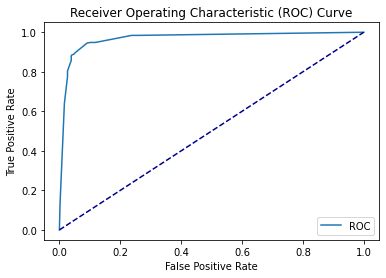

AUC: 0.97


In [32]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

y_probs = best_model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

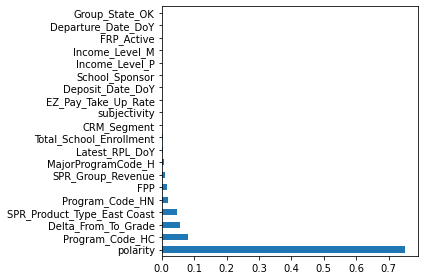

In [33]:
# FEATURE IMPORTANCE:

#feat_importances = dict(zip(X_train.columns, best_model))
feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)
x = feat_importances.nlargest(20)
x.plot(kind='barh')
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()


feat_importances=feat_importances.reset_index()
feat_importances=feat_importances.rename(columns={'index':'features', 0:'importance'})

In [34]:
from sklearn import tree
r = tree.export_text(best_model,feature_names=X_test.columns.tolist())
print(r)

|--- polarity <= -0.00
|   |--- School_Sponsor <= 0.50
|   |   |--- Income_Level_M <= 0.50
|   |   |   |--- FRP_Active <= 40.50
|   |   |   |   |--- polarity <= -0.07
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- polarity >  -0.07
|   |   |   |   |   |--- subjectivity <= 0.68
|   |   |   |   |   |   |--- Total_School_Enrollment <= 1069.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Total_School_Enrollment >  1069.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- subjectivity >  0.68
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- FRP_Active >  40.50
|   |   |   |   |--- Deposit_Date_DoY <= -68.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Deposit_Date_DoY >  -68.50
|   |   |   |   |   |--- class: 0
|   |   |--- Income_Level_M >  0.50
|   |   |   |--- EZ_Pay_Take_Up_Rate <= 0.45
|   |   |   |   |--- EZ_Pay_Take_Up_Rate <= 0.11
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- EZ_Pay_Take_Up_Rate >  0.11
|   

### Random Forest

In [502]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID

classifier = RandomForestClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'n_estimators': [10, 20],
              'max_depth': [4,5,6,7,8,9],
              'min_samples_split': [3,4,5,6,7,8,9],
              'min_samples_leaf': [3,4,5,6,7,8,9]}

In [503]:
#DEFINE YOUR GRIDSEARCH 
'''
GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
'''
gs = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

#TRAIN YOUR CLASSIFIER
gs = gs.fit(X_train, y_train)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

In [504]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.921632 using {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 20}
0.851248 (0.014714) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 10}
0.870682 (0.023839) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}
0.863913 (0.021383) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 10}
0.853746 (0.016111) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 20}
0.853584 (0.022581) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 10}
0.875913 (0.024277) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 20}
0.882828 (0.008213) with: {'criterio

In [505]:
best_model = gs.best_estimator_

#TEST ON YOUR TEST & TRAIN SET 
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

#EVALUATE YOUR PREDICTION (on the y_train)
print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train))

print('\n')

#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred))

***RESULTS ON TRAIN SET***
f1_score:  0.9481401031767581


***RESULTS ON TEST SET***
f1_score:  0.9197994987468672


In [506]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86       489
           1       0.87      0.97      0.92       756

    accuracy                           0.90      1245
   macro avg       0.91      0.88      0.89      1245
weighted avg       0.90      0.90      0.90      1245



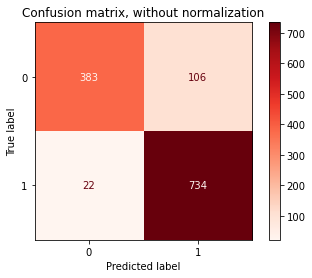

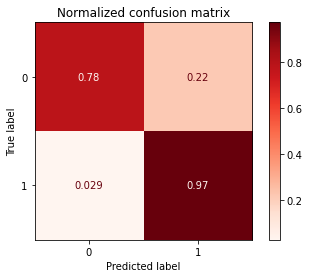

In [507]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_model, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

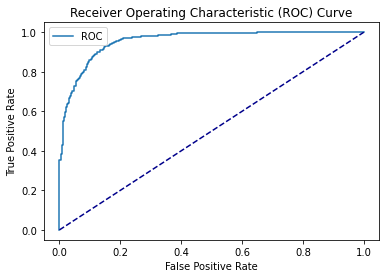

AUC: 0.96


In [508]:
y_pred = best_model.predict(X_test)

y_probs = best_model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

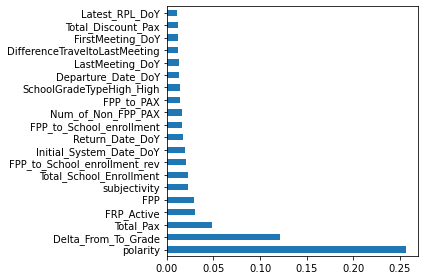

In [509]:
# FEATURE IMPORTANCE:

feat_importances = dict(zip(X_train.columns, best_model))
feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)
x = feat_importances.nlargest(20)
x.plot(kind='barh')
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()


feat_importances=feat_importances.reset_index()
feat_importances=feat_importances.rename(columns={'index':'features', 0:'importance'})